### Importing Dependencies

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime
import xgboost as xgb

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

### Importing Data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
store_df = pd.read_csv('store.csv')

In [4]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [6]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
print(f"Shape of train data: {train_df.shape}")
print(f"Shape of test  data: {test_df.shape}")
print(f"Shape of store data: {store_df.shape}")

Shape of train data: (1017209, 9)
Shape of test  data: (41088, 8)
Shape of store data: (1115, 10)


### Joining

In [8]:
# check if the stores in the train and store dataset align
train_df.Store.nunique() == store_df.Store.nunique()

True

In [9]:
df = train_df.merge(store_df, how='left', left_on=train_df.Store, right_on=store_df.Store)
df.head()

,key_0,Store_x,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Store_y,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,5,2015-07-31,5263,555,1,1,0,1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,2,5,2015-07-31,6064,625,1,1,0,1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,3,5,2015-07-31,8314,821,1,1,0,1,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,4,5,2015-07-31,13995,1498,1,1,0,1,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,5,2015-07-31,4822,559,1,1,0,1,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [10]:
df.drop(['key_0', 'Store_y'], axis=1, inplace=True)
df = df.rename(columns={'Store_x':'Store'})
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [11]:
df.shape

(1017209, 18)

### Understanding the Data

In [12]:
round(df.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.43,321.91,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,4.00,2.00,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.15,464.41,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.83,0.38,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.38,0.49,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,1014567.0,5430.09,7715.32,20.0,710.0,2330.0,6890.0,75860.0
CompetitionOpenSinceMonth,693861.0,7.22,3.21,1.0,4.0,8.0,10.0,12.0
CompetitionOpenSinceYear,693861.0,2008.69,5.99,1900.0,2006.0,2010.0,2013.0,2015.0


There are in total 1115 stores with sales feature having 3849.93 volatility and feature customers having 464.41 volatility with a mean of 5773.82 and 633.15 respectively.

In [13]:
train_df.duplicated().sum(), test_df.duplicated().sum()

(0, 0)

In [14]:
train_df.isnull().sum().sum(), test_df.isnull().sum().sum()

(0, 11)

There are no duplicates and Testing dataset has 11 null values.

In [15]:
print("Training data starts from: {}".format(train_df.Date.min()))
print("Training data end on: {}".format(train_df.Date.max()))
print()
print("Testing data starts from: {}".format(test_df.Date.min()))
print("Testing data end on: {}".format(test_df.Date.max()))

Training data starts from: 2013-01-01
Training data end on: 2015-07-31

Testing data starts from: 2015-08-01
Testing data end on: 2015-09-17


### Exploratory Data Analysis

In [16]:
df.Date = pd.to_datetime(df.Date)
df['Day'] = df.Date.dt.day
df['Month'] = df.Date.dt.month
df['Year'] = df.Date.dt.year
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1270.0,9.0,2008.0,0,NaN,NaN,NaN,31,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,620.0,9.0,2009.0,0,NaN,NaN,NaN,31,7,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,29910.0,4.0,2015.0,0,NaN,NaN,NaN,31,7,2015


Let's explore the seasonality and trend in the dataset.

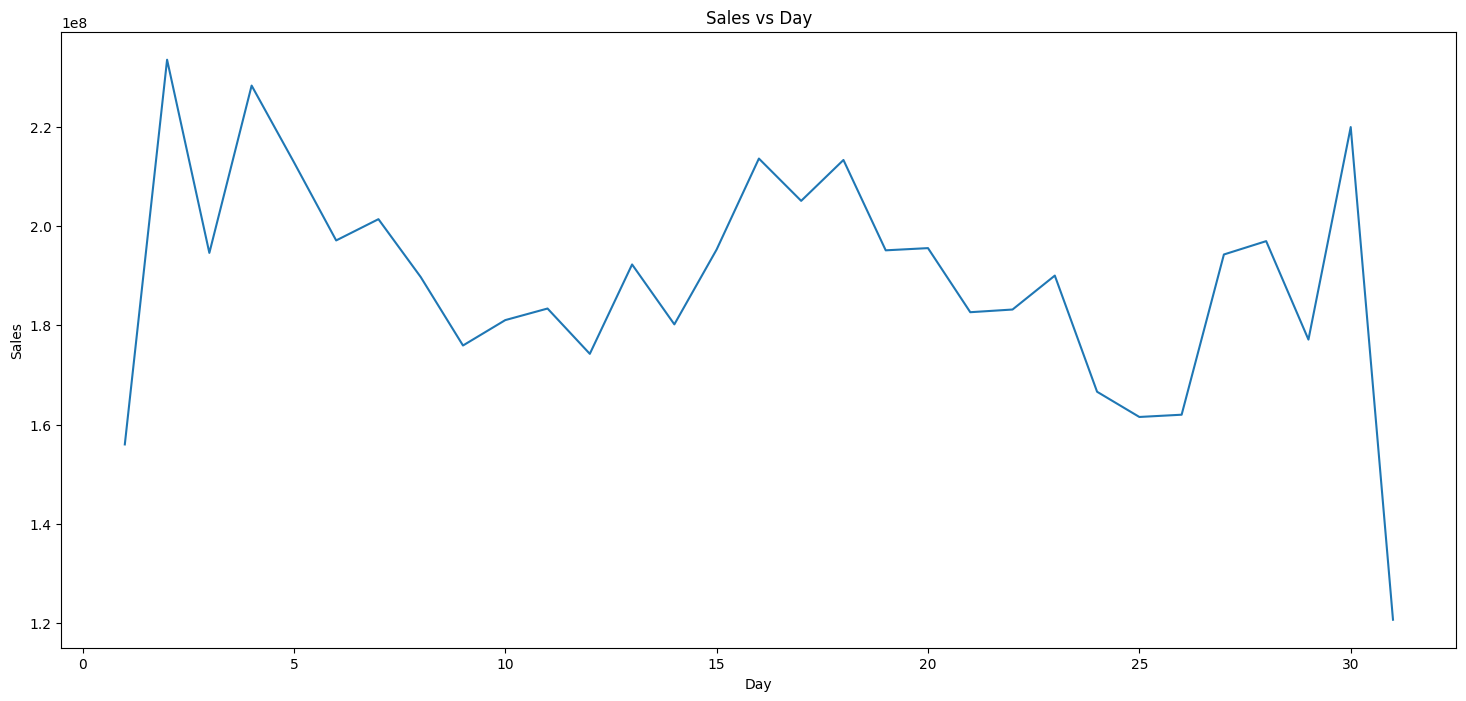

In [17]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby('Day')['Sales'].sum())
plt.title("Sales vs Day")
plt.xlabel("Day")
plt.ylabel("Sales")
plt.show()

From the graph above we see that most sales are done in the beginning of the month with end of the month being the lowest.

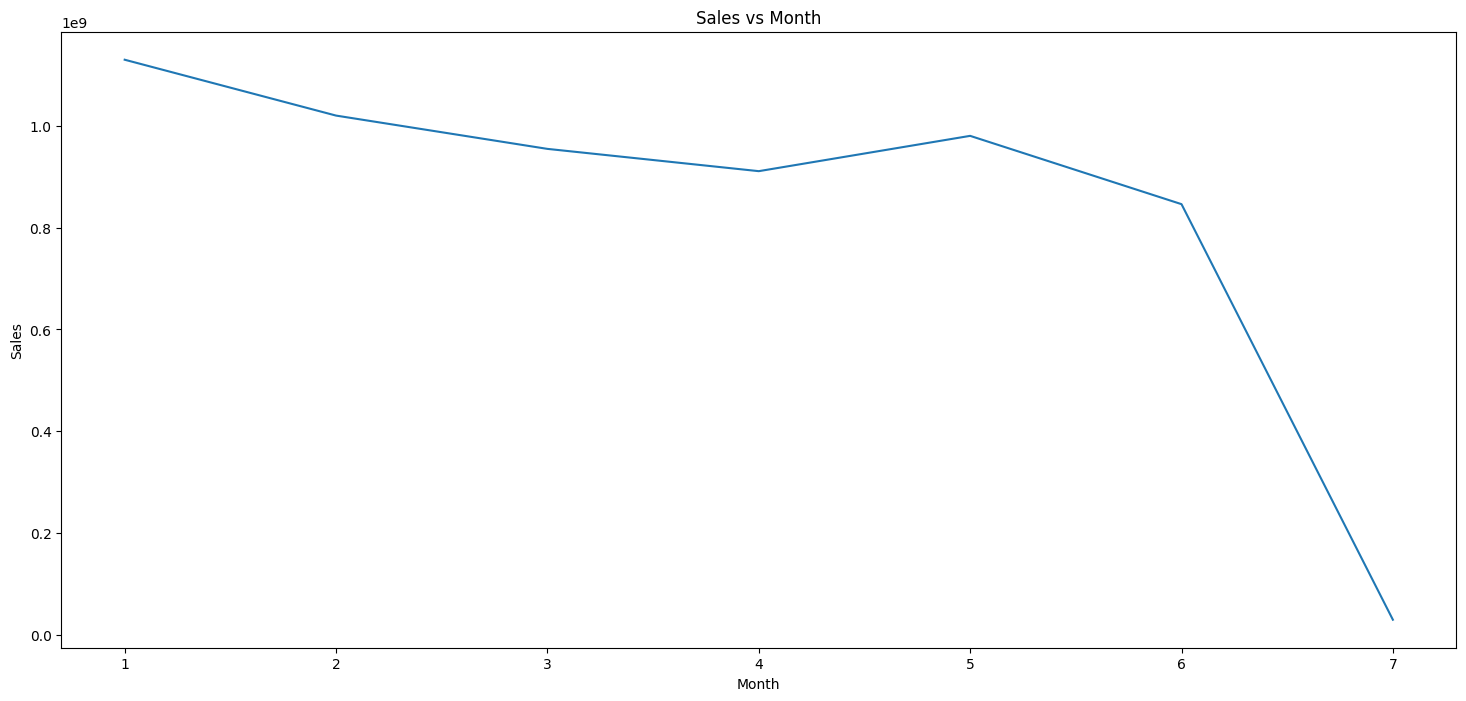

In [18]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby('DayOfWeek')['Sales'].sum())
plt.title("Sales vs Month")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

Sales are more in the beginning of the week than the end.

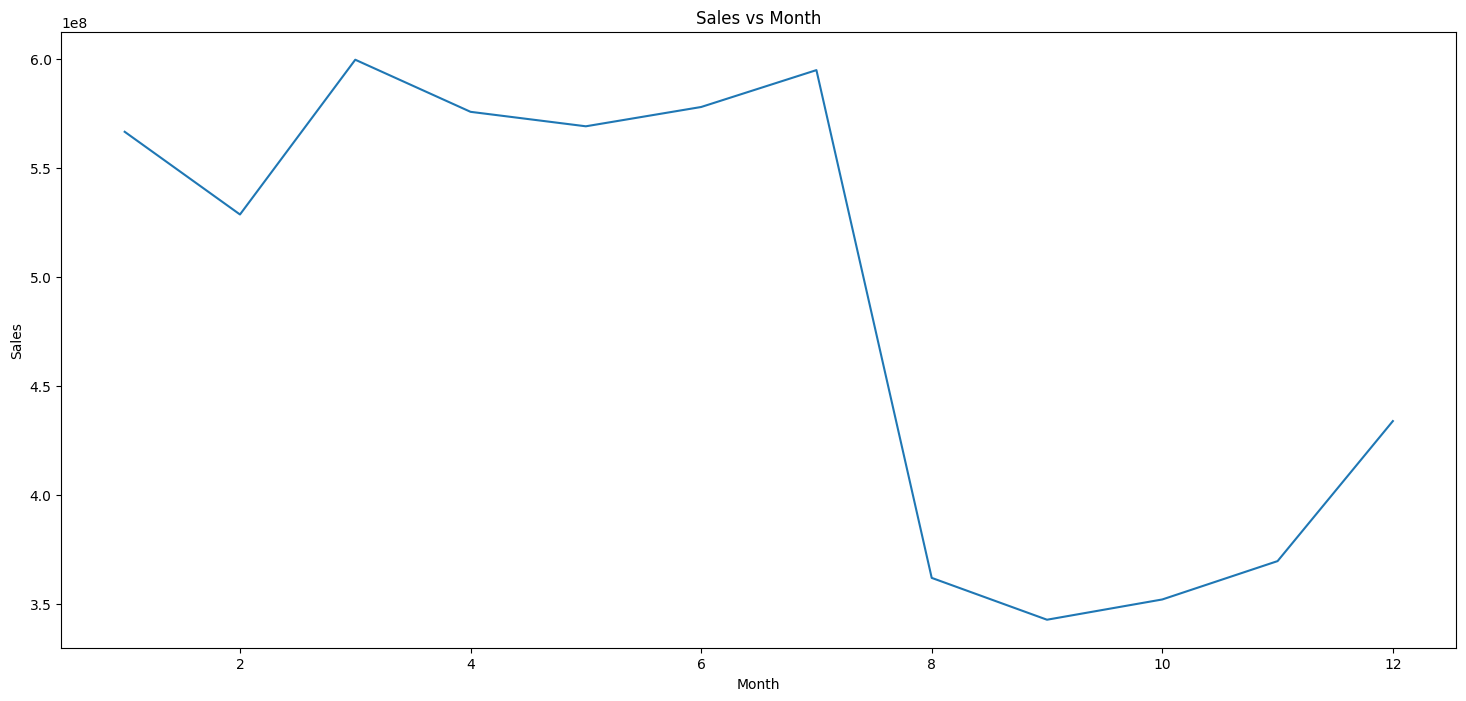

In [19]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby('Month')['Sales'].sum())
plt.title("Sales vs Month")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

Sales are relatively lower by the end of year.

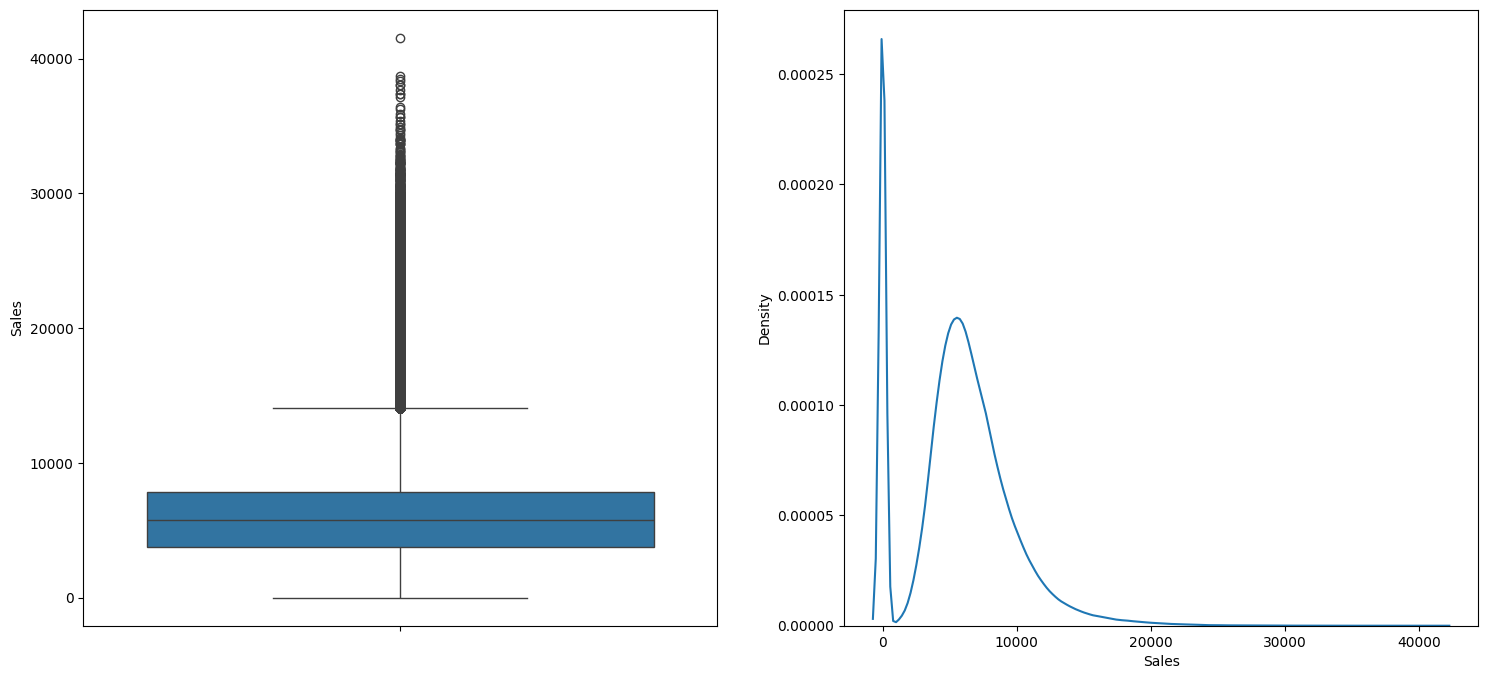

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
sns.boxplot(train_df.Sales, ax=ax1)
sns.kdeplot(train_df.Sales, ax=ax2)
plt.show()

Sales are 0 on a huge amount of days which could mean this is either imputed to fill gaps as it doesn't make sense for sales of a day to be 0! This could mean the store was closed on holidays. Let's test it out.

In [21]:
df[df.Open==0].Sales.value_counts()

Sales
0    172817
Name: count, dtype: int64

Seems like the above hypothesis is right. 172,817 values are filled with 0. Let's fill these values with `np.NaN` as some models like `XGBoost` can handle missing values and it might benefit from it.

In [22]:
# Remove non-numeric columns from train_df and test_df
train_df_numeric = train_df.select_dtypes(include=[np.number])
test_df_numeric = test_df.select_dtypes(include=[np.number])

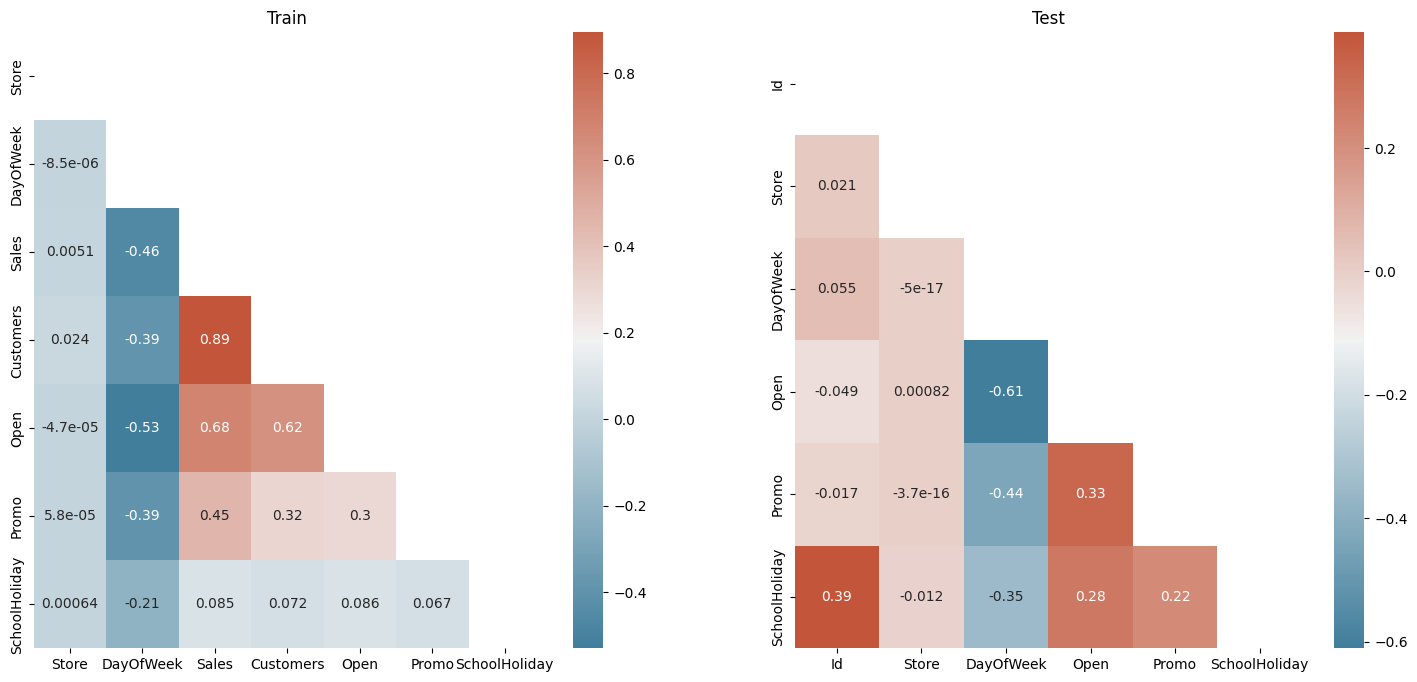

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

corr_train = train_df_numeric.corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool))
sns.heatmap(corr_train, mask=mask_train, cmap=cmap, annot=True, ax=ax1)
ax1.set_title('Train')

corr_test = test_df_numeric.corr()
mask_test = np.triu(np.ones_like(corr_test, dtype=bool))
sns.heatmap(corr_test, mask=mask_test, cmap=cmap, annot=True, ax=ax2)
ax2.set_title('Test')

plt.show()

We see that sales are highly correlated with feature `Customers` and feature `Open` and moderately correlated with `Promo`. Let's see some more plots about this.

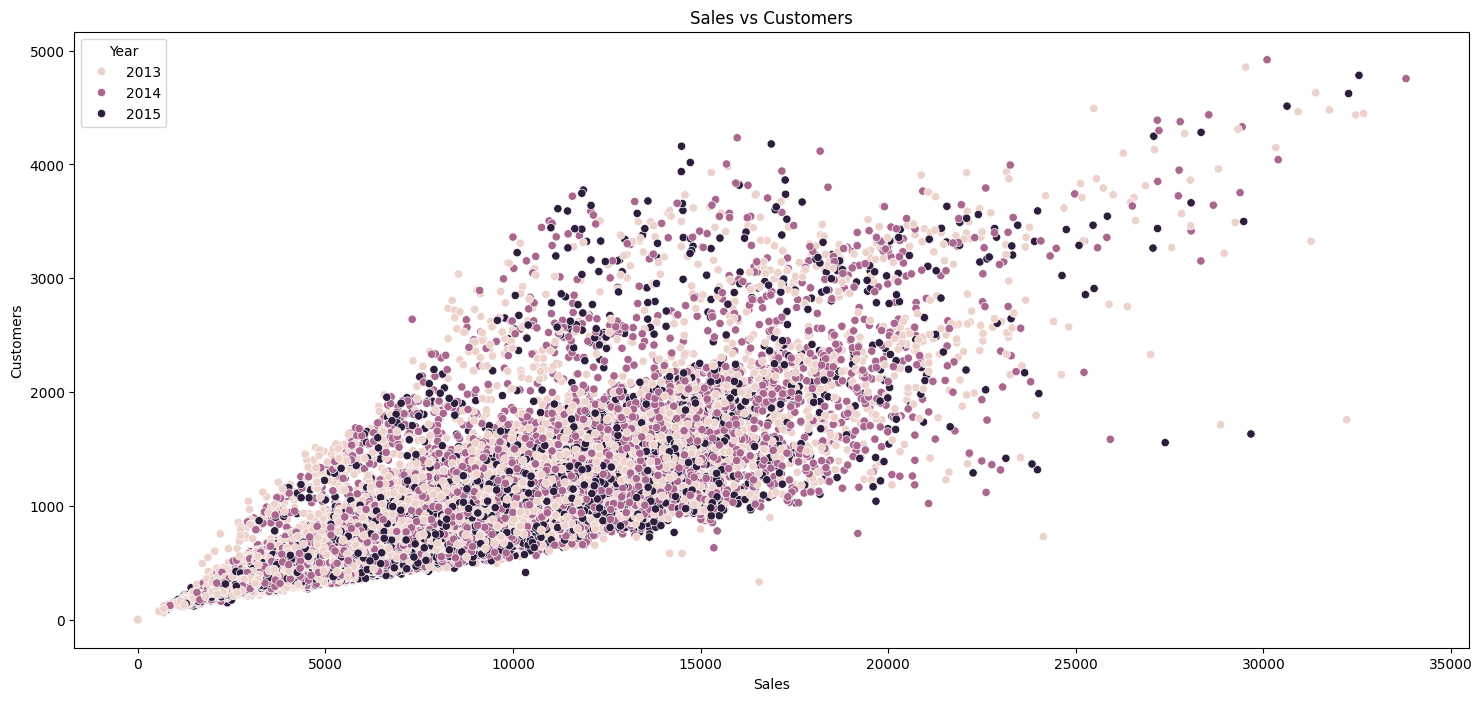

In [24]:
plt.figure(figsize=(18,8))
temp_df = pd.DataFrame(df.sample(100000))
sns.scatterplot(data=temp_df, x='Sales', y='Customers', hue='Year')
plt.title("Sales vs Customers")
plt.show()

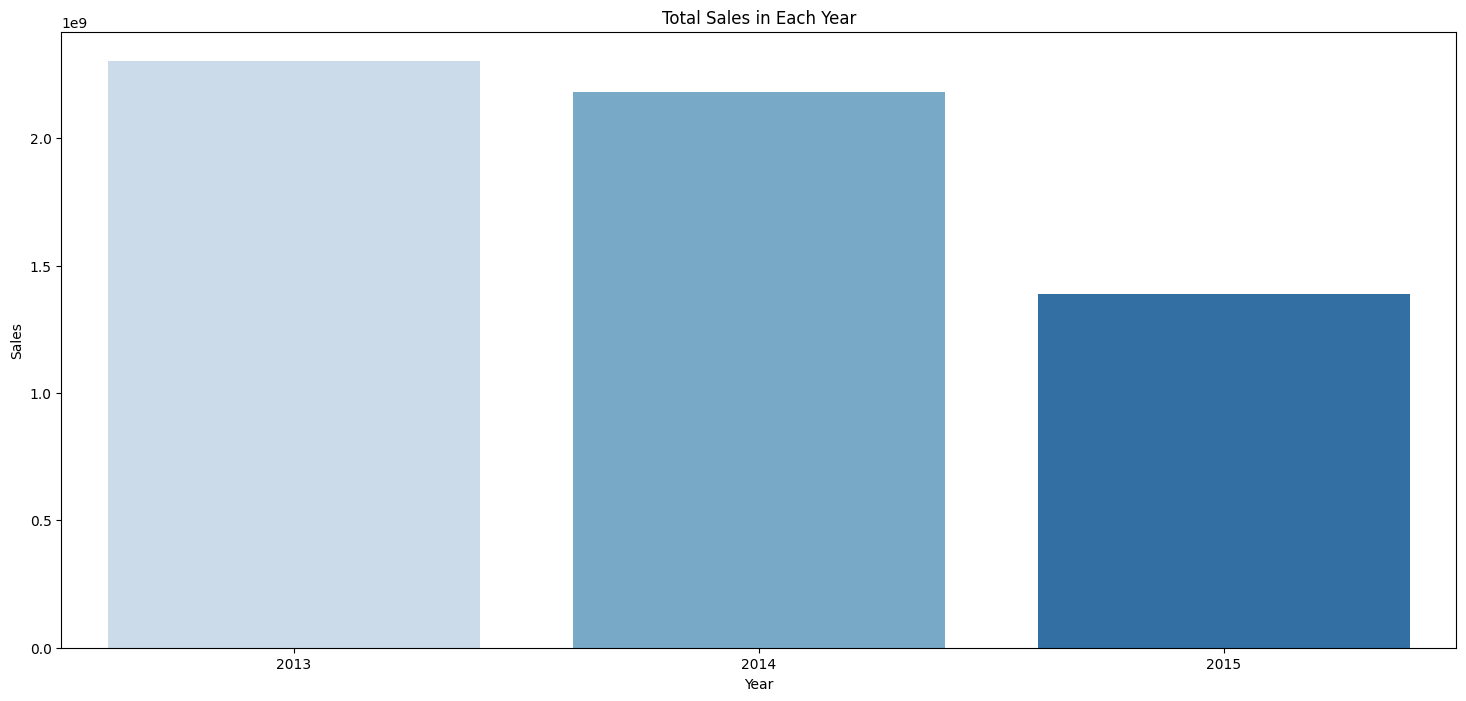

In [25]:
plt.figure(figsize=(18,8))
temp_df = pd.DataFrame(df.groupby('Year')['Sales'].sum()).reset_index()
sns.barplot(x=temp_df['Year'], y=temp_df['Sales'], palette='Blues')
plt.title("Total Sales in Each Year")
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

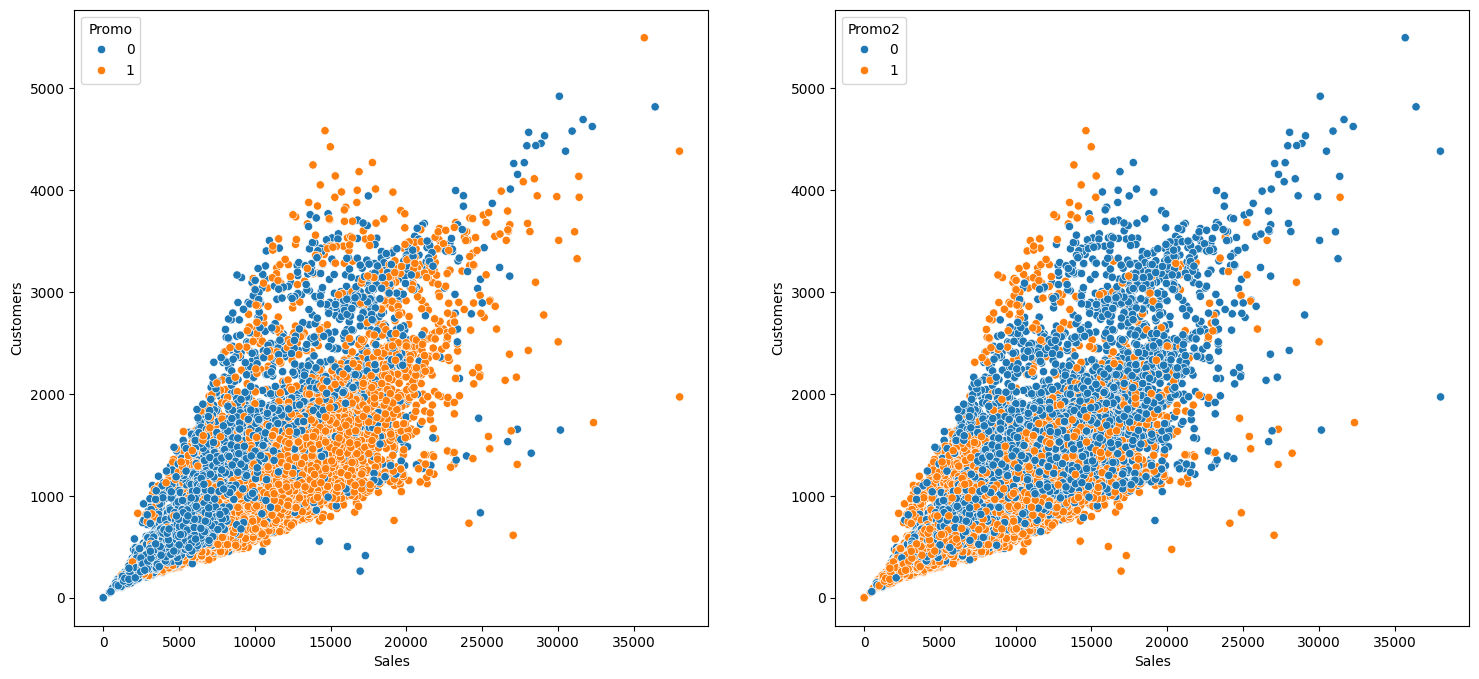

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
temp_df = pd.DataFrame(df.sample(100000))
sns.scatterplot(x=temp_df['Sales'], y=temp_df['Customers'], hue=df['Promo'], ax=ax1)
sns.scatterplot(x=temp_df['Sales'], y=temp_df['Customers'], hue=df['Promo2'], ax=ax2)
plt.show()

It looks like `Promo1` was more successful for the stores. Let's check the `Sales` for each promo on average.

In [27]:
df.groupby(df.Promo).Sales.mean()[1] > df.groupby(df.Promo2).Sales.mean()[1] # `1` means store participated

True

Now let's check if the type of store is a significant feature. Intuitively, stores inventory and ambience should be a huge factor.

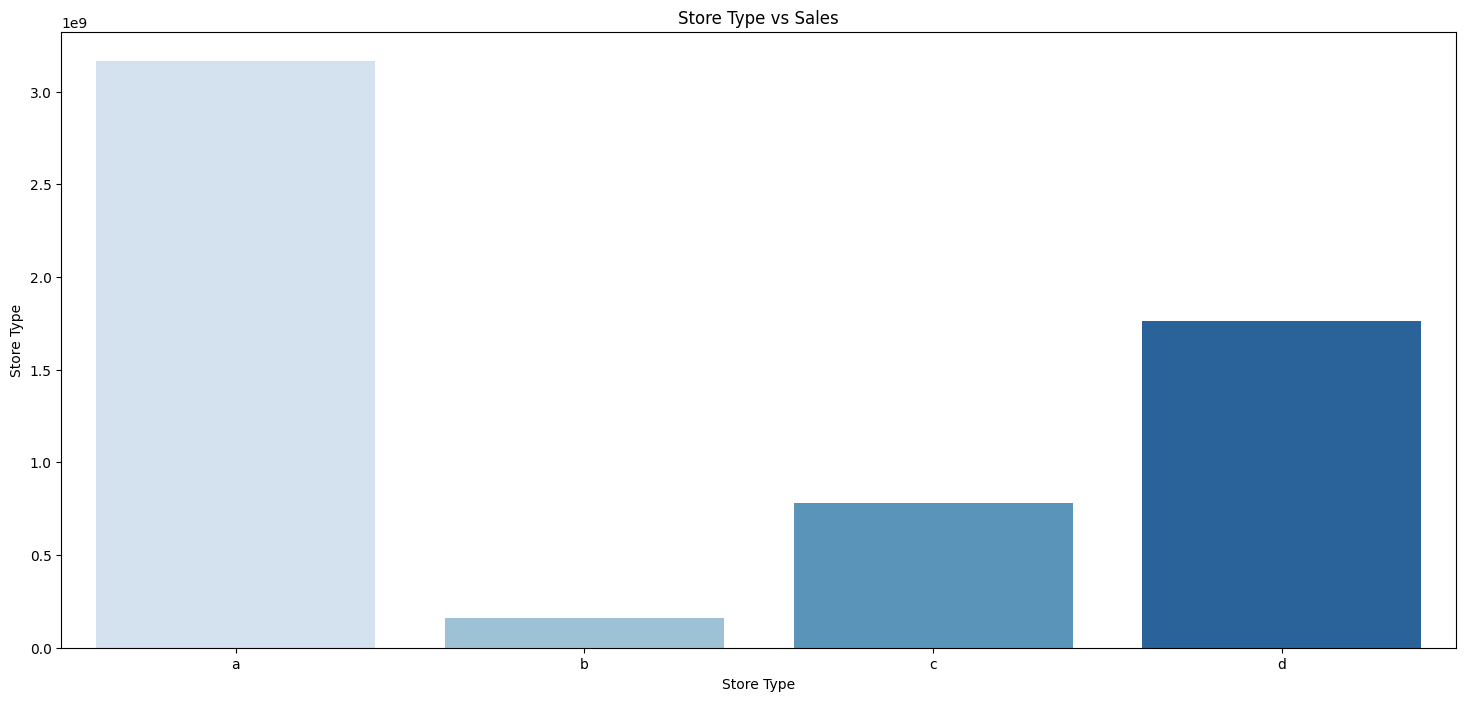

In [28]:
plt.figure(figsize=(18,8))
temp_df = pd.DataFrame(df.groupby('StoreType')['Sales'].sum()).reset_index()
sns.barplot(x=temp_df['StoreType'], y=temp_df['Sales'], palette='Blues')
plt.title("Store Type vs Sales")
plt.xlabel("Store Type")
plt.ylabel("Store Type")
plt.show()

This is interesting. It seems like `Store A` outperform all other stores. Why?

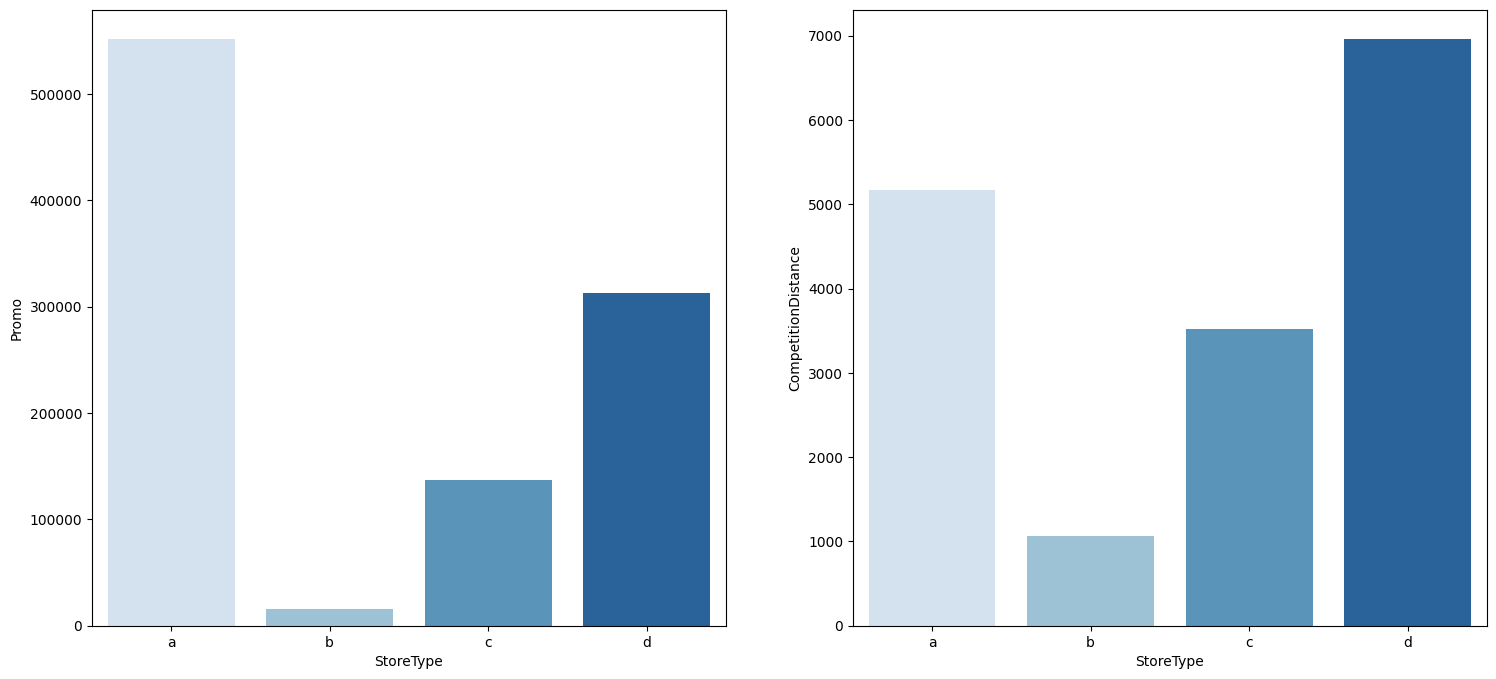

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))

temp_df = pd.DataFrame(df.groupby('StoreType')['Promo'].count()).reset_index()
sns.barplot(x=temp_df['StoreType'], y=temp_df['Promo'], ax=ax1, palette='Blues')

temp_df = pd.DataFrame(df.groupby('StoreType')['CompetitionDistance'].mean()).reset_index()
sns.barplot(x=temp_df['StoreType'], y=temp_df['CompetitionDistance'], ax=ax2, palette='Blues')

plt.show()

We see from the left graph that `Store A` did the most `Promo1`'s inspite of being on average top second in comparison to other stores with regard to `Competition Distance` (distance in meters to the nearest competitor store).

Hence, it's probably fair to say `Promo`'s are important. Other factors could be seasonality, trend, etc.

Let's investigate more about the trend.

In [30]:
temp_df = train_df.copy()
temp_df.Date = pd.to_datetime(temp_df.Date)
temp_df.index = temp_df.Date

# convert 0 sales to NaN
temp_df.Sales = temp_df.Sales.apply(lambda x: None if x==0 else x)

# fill missing values
temp_df.Sales = temp_df.Sales.fillna(method='ffill').fillna(method='bfill')

temp_df = temp_df[['Sales']]
temp_df = temp_df.groupby(temp_df.index).sum()
result = seasonal_decompose(temp_df, model='additive', period=52)

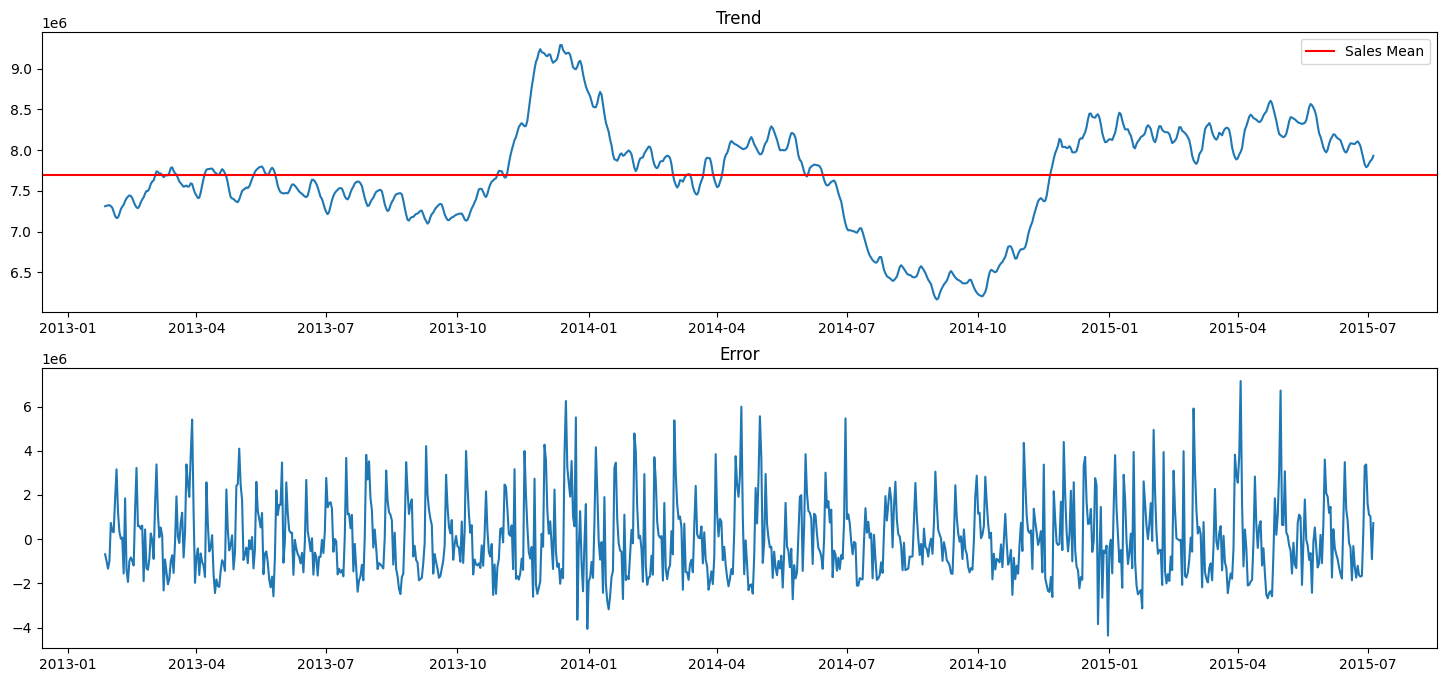

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,8))
ax1.plot(result.trend)
ax1.axhline(y = temp_df.Sales.mean(), color = 'r', linestyle = '-', label='Sales Mean')
ax1.set_title("Trend")
ax2.plot(result.resid)
ax2.set_title("Error")
ax1.legend()
plt.show()

We can see from the graph that 2015 has been a good year as the trend line is above the average line by the end of 2014. Beginning of 2014 there is a huge peak. What drived that?

In [32]:
temp_df = df.copy()
temp_df.index = temp_df.Date
temp_df.Sales = temp_df.Sales.apply(lambda x: None if x == 0 else x)
temp_df.Sales = temp_df.Sales.fillna(method='ffill').fillna(method='bfill')

temp_comp_dist = temp_df.groupby(temp_df.index)['CompetitionDistance'].mean()
temp_comp_osm = temp_df.groupby(temp_df.index)['CompetitionOpenSinceMonth'].mean()

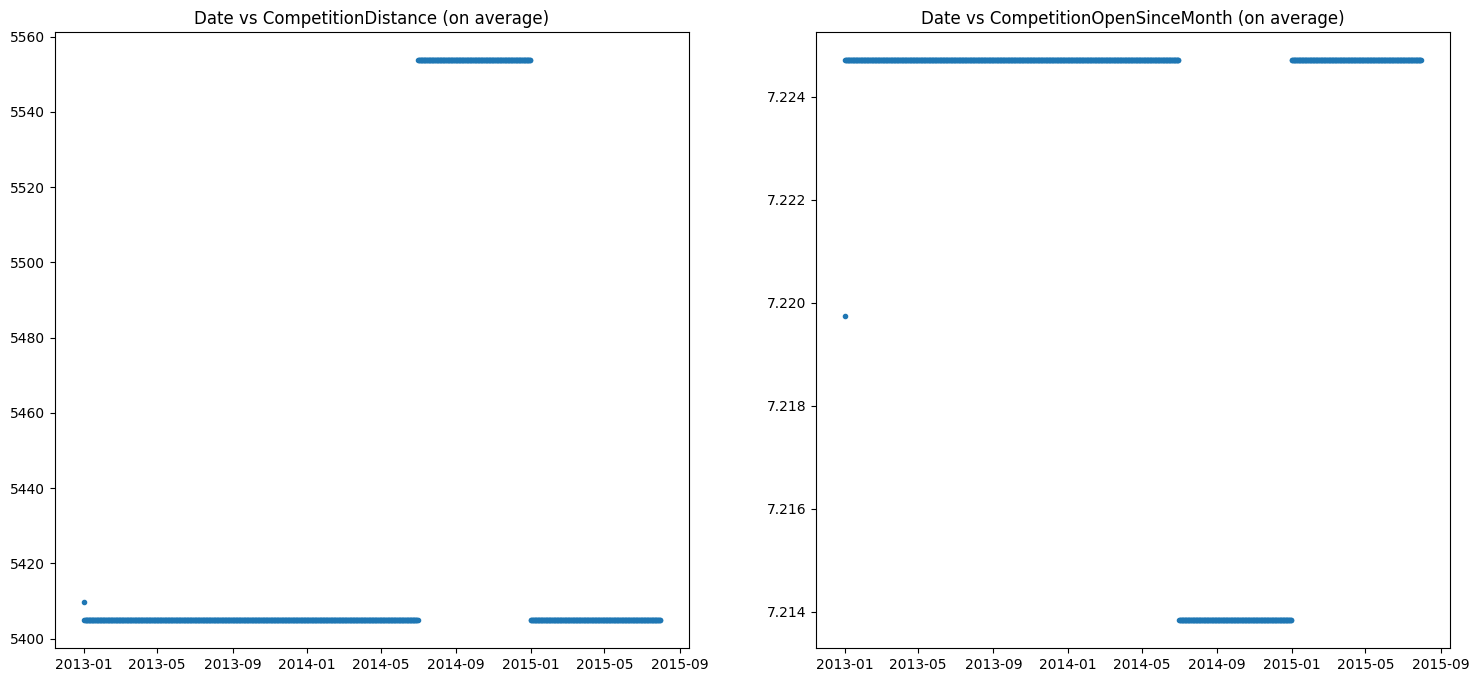

In [33]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))

ax1.plot(temp_comp_dist, '.')
ax1.set_title("Date vs CompetitionDistance (on average)")

ax2.plot(temp_comp_osm, '.')
ax2.set_title("Date vs CompetitionOpenSinceMonth (on average)")

plt.show()

Seems like there was a new competitor near the end of 2014. And since the distance also relatively increased, it could be due to change of location. But these are just assumptions. It could be useful for the model to interpret such behaviour in the future for the stores.

Let's see if the store would have done fewer promos when the trend was going down.

In [34]:
temp_df = df[df['Year'] == 2014]

# Group by 'Month' and sum only the numeric columns
numeric_cols = temp_df.select_dtypes(include=['number']).columns
temp_df = temp_df.groupby('Month')[numeric_cols].sum()

# Handling 0 sales
temp_df['Sales'] = temp_df['Sales'].apply(lambda x: None if x == 0 else x)
temp_df = temp_df.fillna(method='ffill').fillna(method='bfill')

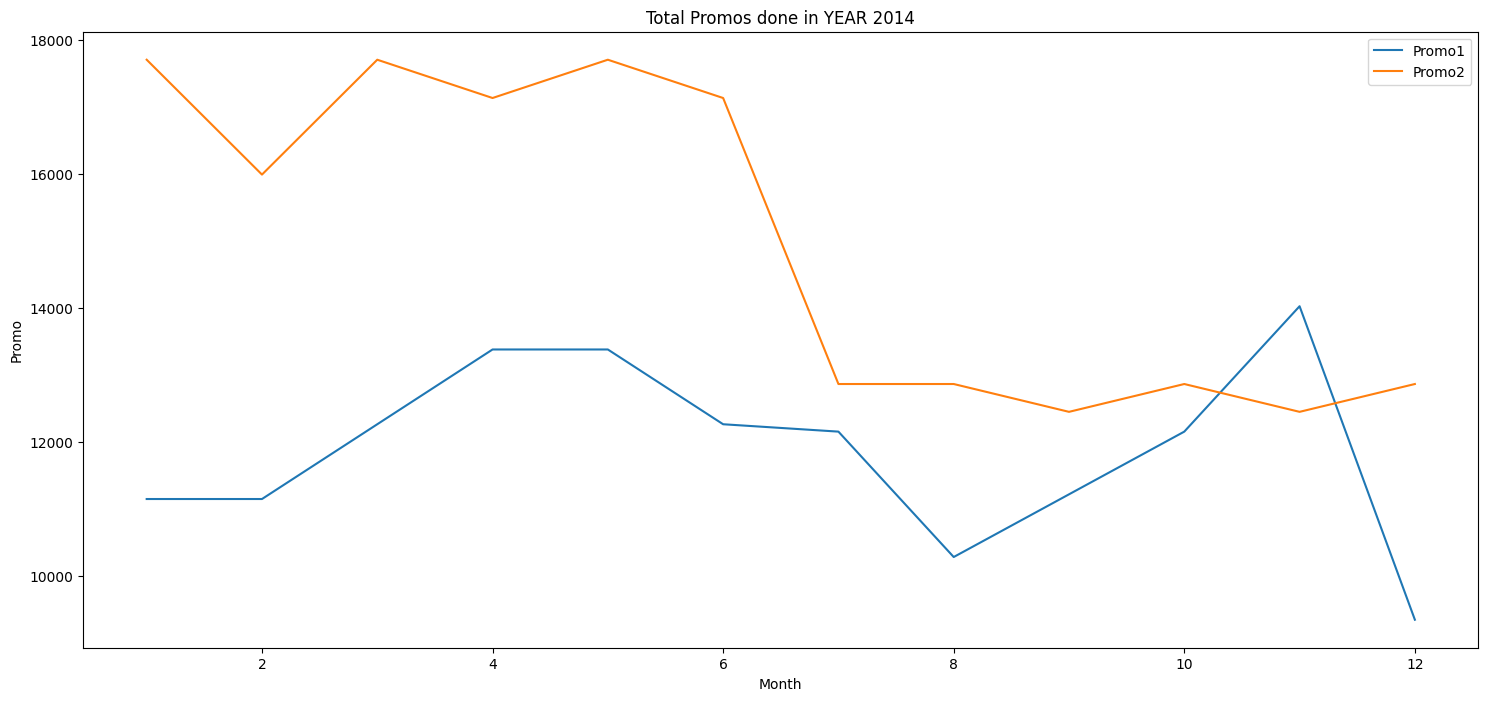

In [35]:
plt.figure(figsize=(18, 8))
plt.title('Total Promos done in YEAR 2014')
sns.lineplot(data=temp_df, x=temp_df.index, y='Promo', palette='Blues', label='Promo1')
sns.lineplot(data=temp_df, x=temp_df.index, y='Promo2', palette='Blues', label='Promo2')
plt.legend()
plt.show()

### Feature Engineering and Preprocessing

In [36]:
features_x = ['Store', 'Date', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday']
features_y = ['SalesLog']

In [37]:
train_df['is_train'] = 1
test_df['is_train'] = 0
df = pd.concat([train_df, test_df])

In [38]:
df.Date = pd.to_datetime(df.Date)  # Converting date to required format

In [39]:
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))]  # Removing rows with Sales 0

In [40]:
df.StateHoliday = df.StateHoliday.map({0:'0', 'a':'a', 'b':'b', 'c':'c', '0':'0'})  # standardize dtype
df.StateHoliday = LabelEncoder().fit_transform(df.StateHoliday)  # Encoding for XG Boost

In [41]:
var_name = 'Date'

df[var_name + 'Day'] = df[var_name].dt.day  # adding day
df[var_name + 'Week'] = df[var_name].dt.isocalendar().week   # adding week
df[var_name + 'Month'] = df[var_name].dt.month  # adding month
df[var_name + 'Year'] = df[var_name].dt.year  # adding year
df[var_name + 'DayOfYear'] = df[var_name].dt.dayofyear  # adding dayofyear

features_x.remove(var_name) #removing Date
features_x.append(var_name + 'Day')
features_x.append(var_name + 'Week')
features_x.append(var_name + 'Month')
features_x.append(var_name + 'Year')
features_x.append(var_name + 'DayOfYear')

In [42]:
store_df.StoreType = LabelEncoder().fit_transform(store_df.StoreType)
store_df.Assortment = LabelEncoder().fit_transform(store_df.Assortment)

In [43]:
join_with = store_df['PromoInterval'].str.split(',').apply(pd.Series)
join_with.columns = join_with.columns.map(lambda x: str(x) + '_PromoInterval')
join_with

,0_PromoInterval,1_PromoInterval,2_PromoInterval,3_PromoInterval
0,NaN,NaN,NaN,NaN
1,Jan,Apr,Jul,Oct
2,Jan,Apr,Jul,Oct
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
1110,Jan,Apr,Jul,Oct
1111,NaN,NaN,NaN,NaN
1112,NaN,NaN,NaN,NaN
1113,NaN,NaN,NaN,NaN


In [44]:
store_df = store_df.join(join_with)  # joining splits
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,0_PromoInterval,1_PromoInterval,2_PromoInterval,3_PromoInterval
0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jan,Apr,Jul,Oct
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jan,Apr,Jul,Oct
3,4,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
def monthToNum(value):
    if(value=='Sept'):
        value='Sep'
    return list(calendar.month_abbr).index(value)

In [46]:
# mapping month abbr to month number
store_df['0_PromoInterval'] = store_df['0_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store_df['1_PromoInterval'] = store_df['1_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store_df['2_PromoInterval'] = store_df['2_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store_df['3_PromoInterval'] = store_df['3_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)

In [47]:
store_df['CompetitionOpenSinceYear'].isna()

0       False
1       False
2       False
3       False
4       False
        ...  
1110    False
1111    False
1112     True
1113     True
1114     True
Name: CompetitionOpenSinceYear, Length: 1115, dtype: bool

In [48]:
competition_open = []
for index, value in store_df[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].iterrows():
    try:
        year, month = int(value['CompetitionOpenSinceYear']), int(value['CompetitionOpenSinceMonth'])
        date = pd.to_datetime(f"{year}-{month}-01", format='%Y-%m-%d')
        competition_open.append(date)
    except Exception as e:
        #print(f"Error processing row {index}: Year={value['CompetitionOpenSinceYear']}, Month={value['CompetitionOpenSinceMonth']} - {e}")
        competition_open.append(np.nan)
competition_open = pd.Series(competition_open)
competition_open.isna().sum()

354

In [49]:
store_df['CompetitionOpen'] = competition_open
store_df['CompetitionOpen'] = store_df['CompetitionOpen'].dt.strftime('%Y%m%d')
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,0_PromoInterval,1_PromoInterval,2_PromoInterval,3_PromoInterval,CompetitionOpen
0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20080901
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1.0,4.0,7.0,10.0,20071101
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1.0,4.0,7.0,10.0,20061201
3,4,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20090901
4,5,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20150401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,0,0,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",1.0,4.0,7.0,10.0,20140601
1111,1112,2,2,1880.0,4.0,2006.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20060401
1112,1113,0,2,9260.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1113,1114,0,2,870.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
promo = []
for index, value in store_df[['Promo2SinceWeek', 'Promo2SinceYear']].iterrows():
    try:
        # Only proceed if neither year nor week is NaN
        if pd.notna(value['Promo2SinceYear']) and pd.notna(value['Promo2SinceWeek']):
            year, week = int(value['Promo2SinceYear']), int(value['Promo2SinceWeek'])
            # Correct format string to include a day of the week (Monday = 0)
            date = pd.to_datetime(f"{year} {week} 1", format='%Y %W %w')
            promo.append(date)
        else:
            promo.append(np.nan)
    except Exception as e:
        print(f"Error processing row {index}: Year={value['Promo2SinceYear']}, Week={value['Promo2SinceWeek']} - {e}")
        promo.append(np.nan)

promo = pd.Series(promo)
promo.isna().sum()

544

In [51]:
store_df['PromoSince'] = promo #converted int to datetime
store_df['PromoSince'] = store_df.PromoSince.dt.strftime('%Y%m%d')

In [52]:
store_features = ['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
                  'PromoSince', '0_PromoInterval']
#1_PromoInterval, 2_PromoInterval, 3_PromoInterval irrelevent

In [53]:
df = pd.merge(df, store_df[store_features], how='left', on=['Store'])
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,is_train,...,DateWeek,DateMonth,DateYear,DateDayOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpen,PromoSince,0_PromoInterval
0,1,5,2015-07-31,5263.0,555.0,1.0,1,0,1,1,...,31,7,2015,212,2,0,1270.0,20080901,NaN,NaN
1,2,5,2015-07-31,6064.0,625.0,1.0,1,0,1,1,...,31,7,2015,212,0,0,570.0,20071101,20100329,1.0
2,3,5,2015-07-31,8314.0,821.0,1.0,1,0,1,1,...,31,7,2015,212,0,0,14130.0,20061201,20110404,1.0
3,4,5,2015-07-31,13995.0,1498.0,1.0,1,0,1,1,...,31,7,2015,212,2,2,620.0,20090901,NaN,NaN
4,5,5,2015-07-31,4822.0,559.0,1.0,1,0,1,1,...,31,7,2015,212,0,0,29910.0,20150401,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058238,1111,6,2015-08-01,NaN,NaN,1.0,0,0,0,0,...,31,8,2015,213,0,0,1900.0,20140601,20130805,1.0
1058239,1112,6,2015-08-01,NaN,NaN,1.0,0,0,0,0,...,31,8,2015,213,2,2,1880.0,20060401,NaN,NaN
1058240,1113,6,2015-08-01,NaN,NaN,1.0,0,0,0,0,...,31,8,2015,213,0,2,9260.0,NaN,NaN,NaN
1058241,1114,6,2015-08-01,NaN,NaN,1.0,0,0,0,0,...,31,8,2015,213,0,2,870.0,NaN,NaN,NaN


In [54]:
features_x = list(set(features_x + store_features))

In [55]:
features_x

['DateDayOfYear',
 'Open',
 'SchoolHoliday',
 'DateWeek',
 'StoreType',
 'Promo',
 'CompetitionDistance',
 'DayOfWeek',
 'DateMonth',
 'CompetitionOpen',
 'Store',
 'PromoSince',
 '0_PromoInterval',
 'DateYear',
 'Assortment',
 'DateDay',
 'StateHoliday']

In [56]:
for feature in features_x:
    df[feature] = df[feature].fillna(-999)  # out of range value for model

In [57]:
df['DateInt'] = df.Date.dt.strftime('%Y%m%d').map(int) #mapping to Int
df['CompetitionOpen'] = df.CompetitionOpen.map(int)
df['PromoSince'] = df.PromoSince.map(int)

In [58]:
df['Zscore'] = (df.Sales - df.Sales.mean())/df.Sales.std()

In [59]:
def check_outlier(value, thresh=4.0):
    return value>=thresh

In [60]:
df['Outlier'] = df.Zscore.apply(check_outlier)

In [61]:
store_data_sales = df.groupby([df['Store']])['Sales'].sum()
store_data_customers = df.groupby([df['Store']])['Customers'].sum()
store_data_open = df.groupby([df['Store']])['Open'].count()

In [62]:
store_data_sales_per_day = store_data_sales / store_data_open
store_data_customers_per_day = store_data_customers / store_data_open
store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day

In [63]:
df_store = pd.merge(store_df, store_data_sales_per_day.reset_index(name='SalesPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_customers_per_day.reset_index(name='CustomersPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_sales_per_customer_per_day.reset_index(name='SalesPerCustomersPerDay'), how='left', on=['Store'])

In [64]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,0_PromoInterval,1_PromoInterval,2_PromoInterval,3_PromoInterval,CompetitionOpen,PromoSince,SalesPerDay,CustomersPerDay,SalesPerCustomersPerDay
0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20080901,NaN,3754.397980,444.972727,8.437366
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1.0,4.0,7.0,10.0,20071101,20100329,4122.991507,486.045648,8.482725
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1.0,4.0,7.0,10.0,20061201,20110404,5462.889899,590.212121,9.255808
3,4,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20090901,NaN,8021.769639,1100.057325,7.292138
4,5,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20150401,NaN,3867.110403,444.360934,8.702634


In [65]:
store_features = ['Store', 'SalesPerDay', 'CustomersPerDay', 'SalesPerCustomersPerDay']

features_x = list(set(features_x + store_features))
df = pd.merge(df, df_store[store_features], how='left', on=['Store'])

In [66]:
holidays_each_day_of_week = df.groupby('DayOfWeek')['StateHoliday'].sum()
df = pd.merge(df, holidays_each_day_of_week.reset_index(name='HolidaysPerDayOfWeek'), on=['DayOfWeek'])

In [67]:
school_holidays_each_day_of_week = df.groupby('DayOfWeek')['SchoolHoliday'].sum()
df = pd.merge(df, school_holidays_each_day_of_week.reset_index(name='SchoolHolidaysPerDayOfWeek'), on=['DayOfWeek'])

In [68]:
promo_each_day_of_week = df.groupby('DayOfWeek')['Promo'].sum()
df = pd.merge(df, promo_each_day_of_week.reset_index(name='PromoPerDayOfWeek'), on=['DayOfWeek'])

In [69]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,is_train,...,0_PromoInterval,DateInt,Zscore,Outlier,SalesPerDay,CustomersPerDay,SalesPerCustomersPerDay,HolidaysPerDayOfWeek,SchoolHolidaysPerDayOfWeek,PromoPerDayOfWeek
0,1,5,2015-07-31,5263.0,555.0,1.0,1,0,1,1,...,-999.0,20150731,-0.132767,False,3754.397980,444.972727,8.437366,12291,39429,80145
1,2,5,2015-07-31,6064.0,625.0,1.0,1,0,1,1,...,1.0,20150731,0.075296,False,4122.991507,486.045648,8.482725,12291,39429,80145
2,3,5,2015-07-31,8314.0,821.0,1.0,1,0,1,1,...,1.0,20150731,0.659742,False,5462.889899,590.212121,9.255808,12291,39429,80145
3,4,5,2015-07-31,13995.0,1498.0,1.0,1,0,1,1,...,-999.0,20150731,2.135404,False,8021.769639,1100.057325,7.292138,12291,39429,80145
4,5,5,2015-07-31,4822.0,559.0,1.0,1,0,1,1,...,-999.0,20150731,-0.247318,False,3867.110403,444.360934,8.702634,12291,39429,80145


In [70]:
holidays_next_week = []
holidays_next_week_index = []
for index, value in df.groupby(df.Date).sum().iterrows():
    start_range = index + datetime.timedelta(days=7)
    end_range = index + datetime.timedelta(days=15)
    school_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).SchoolHoliday)
    state_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).StateHoliday)
    holidays_next_week.append(school_holidays+state_holidays)
    holidays_next_week_index.append(index)
    
holidays_next_week = pd.Series(holidays_next_week)
holidays_next_week.shape

(990,)

In [71]:
holidays_this_week=[]
index_list = []
for index, value in df.groupby(df.Date).sum().iterrows():
    start_range = index 
    end_range = index + datetime.timedelta(days=7)
    school_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).SchoolHoliday)
    state_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).StateHoliday)
    holidays_this_week.append(school_holidays+state_holidays)
    index_list.append(index)
    
holidays_this_week = pd.Series(holidays_this_week)
holidays_this_week.shape

(990,)

In [72]:
holidays_last_week=[]
holidays_last_week_index=[]
for index, value in df.groupby(df.Date).sum().iterrows():
    start_range = index - datetime.timedelta(days=7)
    end_range = index + datetime.timedelta(days=1)
    school_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).SchoolHoliday)
    state_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).StateHoliday)
    holidays_last_week.append(school_holidays+state_holidays)
    holidays_last_week_index.append(index)
    
holidays_last_week = pd.Series(holidays_next_week)
holidays_last_week.shape

(990,)

In [73]:
temp_df = pd.DataFrame({'HolidaysNextWeek':holidays_next_week, 'Date':holidays_next_week_index})
df = pd.merge(df, temp_df, on=['Date'])

In [74]:
temp_df = pd.DataFrame({'HolidaysThisWeek':holidays_this_week, 'Date': index_list})
df = pd.merge(df, temp_df, on=['Date'])

In [75]:
temp_df = pd.DataFrame({'HolidaysLastWeek':holidays_last_week, 'Date': holidays_last_week_index})
df = pd.merge(df, temp_df, on=['Date'])

In [76]:
holidays_features = ['HolidaysPerDayOfWeek', 'SchoolHolidaysPerDayOfWeek', 'PromoPerDayOfWeek', 
                     'HolidaysNextWeek', 'HolidaysThisWeek', 'HolidaysLastWeek']

features_x = list(set(features_x + holidays_features))

In [77]:
#Most Promos are done on DayofWeek 4
df['DaysTillMaxPromo'] = df.DayOfWeek.apply(lambda x: 4-x)

In [78]:
df['PromoTomorrow'] = df.Promo.shift(-1)
df['PromoYesterday'] = df.Promo.shift(1)

In [79]:
promo_features = ['DaysTillMaxPromo', 'PromoTomorrow', 'PromoYesterday']

features_x = list(set(features_x + promo_features))

In [80]:
df.Sales = df.Sales.apply(lambda x: np.nan if x == 0 else x) #Convert 0 to NaNs

In [81]:
df.loc[df['is_train'] == 1, 'SalesLog'] = np.log(1+df.loc[df['is_train'] == 1]['Sales']) #Transforming Sales to 1+log

In [82]:
len(features_x)

29

In [83]:
df.shape

(1058243, 38)

In [84]:
df.isnull().sum().sum()

1527143

### Modelling

In [86]:
data = df.loc[(df['is_train'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)]
data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,is_train,...,HolidaysPerDayOfWeek,SchoolHolidaysPerDayOfWeek,PromoPerDayOfWeek,HolidaysNextWeek,HolidaysThisWeek,HolidaysLastWeek,DaysTillMaxPromo,PromoTomorrow,PromoYesterday,SalesLog
0,1,5,2015-07-31,5263.0,555.0,1.0,1,0,1,1,...,12291,39429,80145,4860,5483,4860,-1,1.0,NaN,8.568646
1,2,5,2015-07-31,6064.0,625.0,1.0,1,0,1,1,...,12291,39429,80145,4860,5483,4860,-1,1.0,1.0,8.710290
2,3,5,2015-07-31,8314.0,821.0,1.0,1,0,1,1,...,12291,39429,80145,4860,5483,4860,-1,1.0,1.0,9.025816
3,4,5,2015-07-31,13995.0,1498.0,1.0,1,0,1,1,...,12291,39429,80145,4860,5483,4860,-1,1.0,1.0,9.546527
4,5,5,2015-07-31,4822.0,559.0,1.0,1,0,1,1,...,12291,39429,80145,4860,5483,4860,-1,1.0,1.0,8.481151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052246,1111,6,2013-01-05,3325.0,291.0,1.0,0,0,0,1,...,579,3394,0,0,1093,0,-2,0.0,0.0,8.109526
1052247,1112,6,2013-01-05,9513.0,856.0,1.0,0,0,0,1,...,579,3394,0,0,1093,0,-2,0.0,0.0,9.160520
1052248,1113,6,2013-01-05,5194.0,569.0,1.0,0,0,0,1,...,579,3394,0,0,1093,0,-2,0.0,0.0,8.555452
1052249,1114,6,2013-01-05,18856.0,3065.0,1.0,0,0,0,1,...,579,3394,0,0,1093,0,-2,0.0,0.0,9.844639


In [87]:
x_train, x_test, y_train, y_test = train_test_split(data[features_x],
                                                    data[features_y],
                                                    test_size=0.1,
                                                    random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(757442, 29) (757442, 1) (84161, 29) (84161, 1)


In [88]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

In [89]:
num_round = 20000
evallist = [(dtrain, 'train'), (dtest, 'test')]

param = {'max_depth': 9,
         'eta': 0.01,
         'subsample': 0.75,
         'colsample_bytree': 0.6,
         'objective': 'reg:squarederror'}

plst = list(param.items())

In [91]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [92]:
model = xgb.train(plst, dtrain, num_round, evallist, 
                  feval=rmspe_xg, verbose_eval=25, early_stopping_rounds=250)

[0]	train-rmse:0.41563	train-rmspe:0.55320	test-rmse:0.41585	test-rmspe:0.52216
[25]	train-rmse:0.34533	train-rmspe:0.44802	test-rmse:0.34544	test-rmspe:0.41358
[50]	train-rmse:0.29635	train-rmspe:0.38298	test-rmse:0.29639	test-rmspe:0.34607
[75]	train-rmse:0.25798	train-rmspe:0.33647	test-rmse:0.25798	test-rmspe:0.29654
[100]	train-rmse:0.22859	train-rmspe:0.30349	test-rmse:0.22861	test-rmspe:0.26071
[125]	train-rmse:0.20721	train-rmspe:0.27991	test-rmse:0.20725	test-rmspe:0.23535
[150]	train-rmse:0.18997	train-rmspe:0.26288	test-rmse:0.19004	test-rmspe:0.21556
[175]	train-rmse:0.17745	train-rmspe:0.24981	test-rmse:0.17755	test-rmspe:0.20103
[200]	train-rmse:0.16803	train-rmspe:0.23984	test-rmse:0.16821	test-rmspe:0.19022
[225]	train-rmse:0.16048	train-rmspe:0.23222	test-rmse:0.16073	test-rmspe:0.18149
[250]	train-rmse:0.15433	train-rmspe:0.22608	test-rmse:0.15467	test-rmspe:0.17428
[275]	train-rmse:0.14946	train-rmspe:0.22051	test-rmse:0.14989	test-rmspe:0.16866
[300]	train-rmse:0.14

<Figure size 1800x800 with 0 Axes>

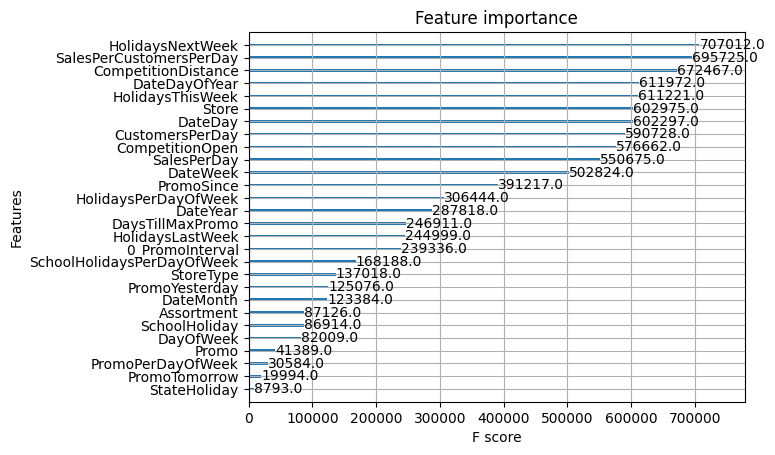

In [93]:
# Print Feature Importance
plt.figure(figsize=(18,8))
xgb.plot_importance(model)
plt.show()

In [94]:
print("Best iteration:", model.best_iteration)
print("Best score:", model.best_score)

Best iteration: 19997
Best score: 0.092764
